In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
dataset = 'dataset/'

When training a deep learning network we are mindful about:
1. Data
2. Scoring function
3. Loss function
4. Weights and bias

Gradient Descent is attempting to optimize our parameters for low loss and high classification accuracy via an iterative process of taking a step  in the direction that minimizes the loss. Learning rate is one of the two hyper parameters that is set for finding the optimal convergence. The other parameter defined later is the regularization penalty.

In [3]:
# Set hyperparameters
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 5
BS = 8

In [4]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset))

data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    print(f"label {label} on image {imagePath}")

    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224)) # Explain why 224 and not Dr Cohen's 227px

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
# Each encoded label consists of a two element array with one of the elements being 
# “hot” (i.e., 1) versus “not” (i.e., 0).
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...
label covid on image dataset/dataset/covid/ryct.2020200034.fig5-day7.jpeg
label covid on image dataset/dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg
label covid on image dataset/dataset/covid/radiol.2020200490.fig3.jpeg
label covid on image dataset/dataset/covid/ryct.2020200034.fig2.jpeg
label covid on image dataset/dataset/covid/ryct.2020200034.fig5-day0.jpeg
label covid on image dataset/dataset/covid/ryct.2020200028.fig1a.jpeg
label covid on image dataset/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg
label covid on image dataset/dataset/covid/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
label covid on image dataset/dataset/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg
label covid on image dataset/dataset/covid/radiopedia-covid-19-pneumonia-2.jpg
label covid on image dataset/dataset/covid/nejmoa2001191_f1-PA.jpeg
label covid on image dataset/dataset/covid/nejmoa2001191_f5-PA.jpeg
label covid on image dataset/dataset/covid/l

In [5]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [6]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

While the word “augment” means to make something “greater” or “increase” something (in this case, data), the Keras ImageDataGenerator class actually works by:

Accepting a batch of images used for training.
Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
Replacing the original batch with the new, randomly transformed batch.
Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).
The Keras ImageDataGenerator class is not an “additive” operation. It’s not taking the original data, randomly transforming it, and then returning both the original data and transformed data.

Instead, the ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.

In [7]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [9]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [10]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [11]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


Regularization penalty - Data Augmentation - efforts to reduce test error at expense of increased training error (overfitting). 

In [12]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 524s 105s/step - loss: 0.5650 - acc: 0.7500 - val_loss: 0.6417 - val_acc: 0.5455
Epoch 2/5
5/5 [==============================] - 528s 106s/step - loss: 0.9378 - acc: 0.4500 - val_loss: 0.6544 - val_acc: 0.5455
Epoch 3/5
5/5 [==============================] - 558s 112s/step - loss: 0.8408 - acc: 0.5500 - val_loss: 0.6131 - val_acc: 0.5455
Epoch 4/5
5/5 [==============================] - 514s 103s/step - loss: 0.8804 - acc: 0.5000 - val_loss: 0.6087 - val_acc: 0.9091
Epoch 5/5
5/5 [==============================] - 555s 111s/step - loss: 0.7498 - acc: 0.6250 - val_loss: 0.5998 - val_acc: 0.9091


In [13]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [14]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.83      0.91         6
      normal       0.83      1.00      0.91         5

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



In pattern recognition, information retrieval and classification (machine learning), precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of the total amount of relevant instances that were actually retrieved.

As you can see from the results above, our automatic COVID-19 detector is obtaining ~91-92% 
accuracy on our sample dataset based solely on X-ray images — no other data, 
including Non-identifying demographics, such as age, sex, ethnicity; History of present illness, including exposure/travel and symptom history; Medical history, including major comorbidities and frailty assessment; Clinical / nursing observations, such as vital signs; All laboratory tests performed etc. was used to train this model.

In [15]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [16]:
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 1]
 [0 5]]
acc: 0.9091
sensitivity: 0.8333
specificity: 1.0000


We are also obtaining 100% sensitivity and 80% specificity implying that:

1. Of patients that do have COVID-19 (i.e., true positives), we could accurately identify them 
as “COVID-19 positive” 100% of the time using our model.
2. Of patients that do not have COVID-19 (i.e., true negatives), we could accurately identify them 
as “COVID-19 negative” only 80% of the time using our model.

Being able to accurately detect COVID-19 with 100% accuracy is great; however, our true negative rate is a bit concerning — we don’t want to classify someone as “COVID-19 negative” when they are “COVID-19 positive”.

In fact, the last thing we want to do is tell a patient they are COVID-19 negative, and then have them go home and infect their family and friends; thereby transmitting the disease further.

We also want to be really careful with our false positive rate — we don’t want to mistakenly classify someone as “COVID-19 positive”, quarantine them with other COVID-19 positive patients, and then infect a person who never actually had the virus.

Balancing sensitivity and specificity is incredibly challenging when it comes to medical applications, especially infectious diseases that can be rapidly transmitted, such as COVID-19.

When it comes to medical computer vision and deep learning, we must always be mindful of the fact that our predictive models can have very real consequences — a missed diagnosis can cost lives.

Again, these results are gathered for proof of concept only. The accompanying results dont conform to the TRIPOD guidelines on reporting predictive models.

KeyError: 'accuracy'

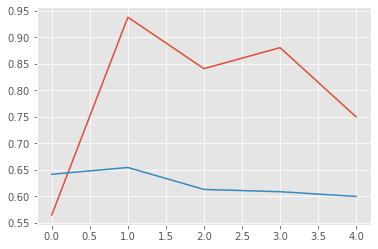

In [17]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plots_5eps.png')

As our training history plot shows, our network is not overfitting, despite having very limited training data:

In [18]:
# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
model.save('covid-19-model-5eps', save_format="h5")

[INFO] saving COVID-19 detector model...


## Limitations, improvements, and future work

### 1. We simply don’t have enough (reliable) data to train a COVID-19 detector.

Hospitals are already overwhelmed with the number of COVID-19 cases, and given patients rights and confidentiality, it becomes even harder to assemble quality medical image datasets in a timely fashion.

We imagine in the next 12-18 months we’ll have more high quality (age,sex,race,co-morbidity (underlying illness))COVID-19 image datasets; but for the time being, we can only make do with what we have.

For the COVID-19 detector to be deployed in the field, it would have to go through rigorous testing by trained medical professionals, working hand-in-hand with expert deep learning practitioners. The method covered here today is certainly in that direction, but is meant for proof of concept purposes only.

### 2. Furthermore, we need to be concerned with what the model is actually “learning”.

It’s possible that our model is learning patterns that are not relevant to COVID-19, and instead are just variations between the two data splits (i.e., positive versus negative COVID-19 diagnosis).

It will take medical professionals and rigorous testing to validate the results coming out of our COVID-19 detector.

In [59]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
network=load_model('covid-19-model-5eps')

In [64]:
from keras.preprocessing.image import load_img,img_to_array

img=load_img(
    'covid.jpeg',
    target_size=(224, 224)
)
# Explain why 224 and not Dr Cohen's 227px

img_array=img_to_array(img)

img_array=tf.expand_dims(img_array,0)

In [65]:
predictions = network.predict(img_array,steps=1)
score = tf.nn.softmax(predictions[0])


In [66]:
print(predictions)

[[0.01455611 0.9854439 ]]


In [67]:
class_names = ['covid','normal']

class_names[np.argmax(predictions)]


'normal'